<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C3W3_IMDB_Reviews_with_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
# Import TensorFlow datasets
import tensorflow_datasets as tfds

# Define imdb set and info set which contain 50,000 movie reviews which are classified as positive of negative
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [0]:
import numpy as np

# Get imdb training and test data
train_data, test_data = imdb['train'], imdb['test']

# Create sentences and labels list
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Copy the contents of tensors into lists
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

# Convert training and testing labels into np.array   
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [11]:
# Check file numbers
print("training_sentences numbers: ", len(training_sentences))
print("training_labels numbers: ", len(training_labels))
print("testing_sentences numbers: ", len(testing_sentences))
print("testing_labels numbers: ", len(testing_labels))

training_sentences numbers:  25000
training_labels numbers:  25000
testing_sentences numbers:  25000
testing_labels numbers:  25000


In [0]:
# Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Tokenizer will then be fit on the training_sentences
tokenizer.fit_on_texts(training_sentences)

# Word index of tokenizer
word_index = tokenizer.word_index

# Convert training_sentences into sequence of numbers
sequences = tokenizer.texts_to_sequences(training_sentences)
# Padding zero after the sentense
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Convert testing_sequences into sequence of numbers and padding them
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [13]:
# Convert word_index form to the form {5: 'mother', 6: 'father'}
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [14]:
# Build the model with GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training the model
num_epochs = 50

history = model.fit(
    padded,
    training_labels_final,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels_final)
)

Epoch 1/50
782/782 [==============================] - 15s 19ms/step - loss: 0.5384 - accuracy: 0.6923 - val_loss: 0.3546 - val_accuracy: 0.8470
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 0.3032 - accuracy: 0.8761 - val_loss: 0.3493 - val_accuracy: 0.8468
Epoch 3/50
782/782 [==============================] - 15s 19ms/step - loss: 0.2292 - accuracy: 0.9122 - val_loss: 0.3852 - val_accuracy: 0.8361
Epoch 4/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1731 - accuracy: 0.9360 - val_loss: 0.4447 - val_accuracy: 0.8324
Epoch 5/50
782/782 [==============================] - 15s 19ms/step - loss: 0.1278 - accuracy: 0.9564 - val_loss: 0.5360 - val_accuracy: 0.8211
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.0944 - accuracy: 0.9684 - val_loss: 0.5874 - val_accuracy: 0.8198
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.0668 - accuracy: 0.9786 - val_loss: 0.6526 - val_accuracy:

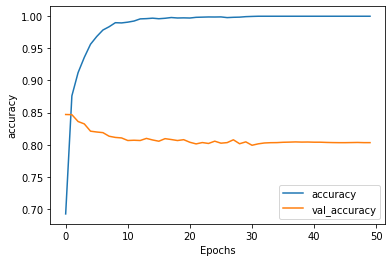

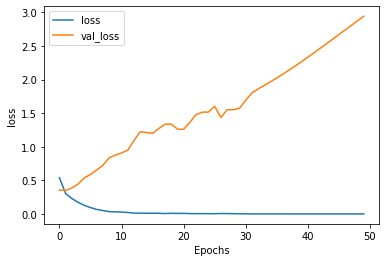

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [17]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Training the model
num_epochs = 50

history = model.fit(
    padded,
    training_labels_final,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels_final)
)

Epoch 1/50
782/782 [==============================] - 15s 19ms/step - loss: 0.5212 - accuracy: 0.7310 - val_loss: 0.4636 - val_accuracy: 0.8194
Epoch 2/50
782/782 [==============================] - 15s 19ms/step - loss: 0.3186 - accuracy: 0.8727 - val_loss: 0.3949 - val_accuracy: 0.8376
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2476 - accuracy: 0.9071 - val_loss: 0.5449 - val_accuracy: 0.8137
Epoch 4/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2022 - accuracy: 0.9264 - val_loss: 0.4336 - val_accuracy: 0.8326
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1598 - accuracy: 0.9432 - val_loss: 0.4960 - val_accuracy: 0.8284
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1340 - accuracy: 0.9520 - val_loss: 0.6478 - val_accuracy: 0.8222
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1078 - accuracy: 0.9630 - val_loss: 0.6664 - val_accuracy:

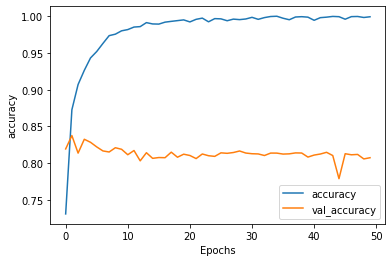

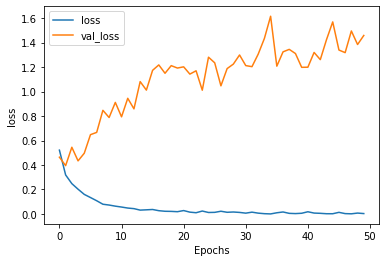

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [20]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Training the model
num_epochs = 50

history = model.fit(
    padded,
    training_labels_final,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels_final)
)

Epoch 1/50
782/782 [==============================] - 6s 7ms/step - loss: 0.5347 - accuracy: 0.7670 - val_loss: 0.4427 - val_accuracy: 0.8409
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 0.3645 - accuracy: 0.8779 - val_loss: 0.4077 - val_accuracy: 0.8386
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2842 - accuracy: 0.9087 - val_loss: 0.4116 - val_accuracy: 0.8326
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2319 - accuracy: 0.9272 - val_loss: 0.4502 - val_accuracy: 0.8338
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1950 - accuracy: 0.9410 - val_loss: 0.4905 - val_accuracy: 0.8298
Epoch 6/50
782/782 [==============================] - 5s 7ms/step - loss: 0.1649 - accuracy: 0.9527 - val_loss: 0.5417 - val_accuracy: 0.8219
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1433 - accuracy: 0.9616 - val_loss: 0.6214 - val_accuracy: 0.8254
Epoch 

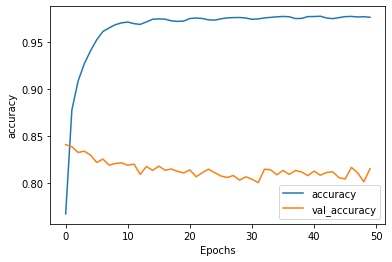

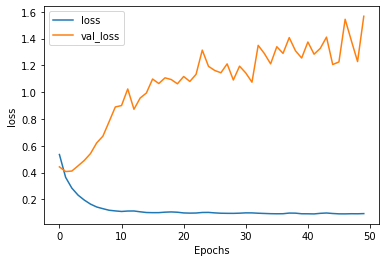

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')